# Sluggish Random Walker

### Discrete time sluggish random walk

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In a sluggish walk, the particle becomes less likely to move when it is far from the origin.

The probability to hop left or right is:
$$\dfrac{1}{\left(\frac{|x|}{a}\right)^\alpha+2}$$

and the probability to stay in place is:
$$\dfrac{\left(\frac{|x|}{a}\right)^\alpha}{\left(\frac{|x|}{a}\right)^\alpha+2}$$

In this instance, the generated random number (r) will be compared to the the movement probabilities.


In [ ]:
def sluggish_walk_discrete(T, alpha):
    """Simulate a single sluggish random walk over T steps for a given alpha."""
    x = np.zeros(T+1)
    for t in range(1, T+1):
        pos = x[t-1]
        denom = abs(pos)**alpha + 2
        p = 1 / denom
        r = np.random.rand()

        if r < p:
            x[t] = pos + 1
        elif r < 2*p:
            x[t] = pos - 1
        else:
            x[t] = pos  # stay
    return x

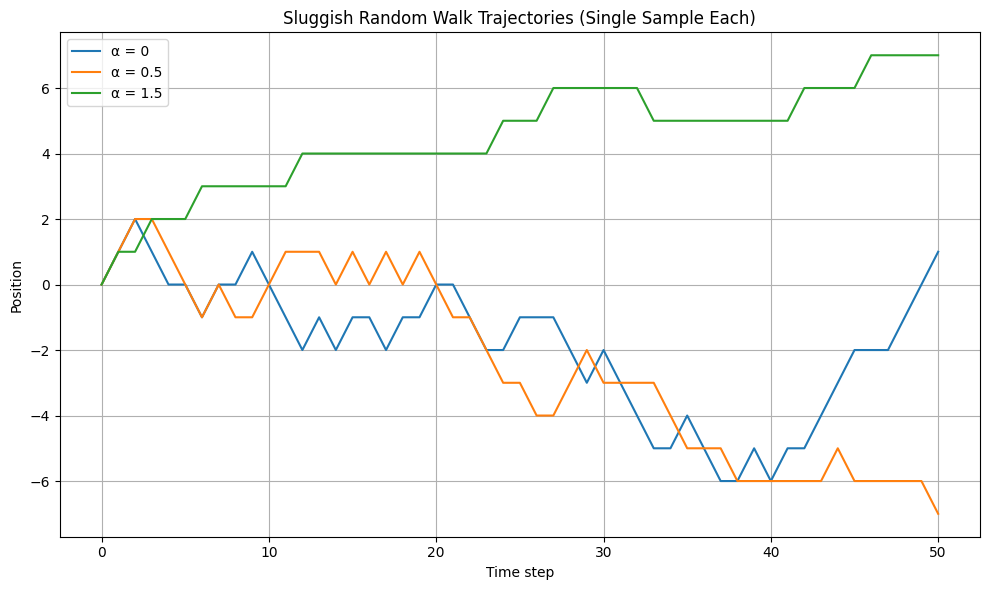

In [ ]:
def plot_trajectories(T, alpha_values):
    plt.figure(figsize=(10, 6))
    for alpha in alpha_values:
        walk = sluggish_walk_discrete(T, alpha)
        plt.plot(walk, label=f'α = {alpha}', linewidth=1.5)
    plt.title('Sluggish Random Walk Trajectories (Single Sample Each)')
    plt.xlabel('Time step')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Usage
T = 50
alpha_values = [0, 0.5, 1.5]
plot_trajectories(T, alpha_values)

### Continuous time sluggish random walk

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

We can also simulate a stochastic differential equation (SDE) describing continuous-space sluggish diffusion, where the diffusivity depends inversely on the particle's current position.

From the continuous master equation of a sluggish random walk derived in the notes:
$$
\dfrac{\partial P(x,t|x_0)}{\partial t}=\dfrac{\partial^2}{\partial x^2}\left[\dfrac{P(x,t|x_0)}{|x|^{\alpha}}\right],
$$

We can write its respective langevin equation (SDE) in the form:
$$
\dot{x(t)}=\sqrt{2D(x)}\eta(t)
$$
where $D(x) = \dfrac{1}{|x|^{\alpha}+\epsilon}$ and $\eta(t)$ is Gaussian white noise satisfying:
$$
⟨η(t)⟩=0,   ⟨η(t)η(t′)⟩=δ(t−t′)
$$

With this SDE, numerical schemes like Euler–Maruyama can be used to make simulations.

In [ ]:
def sluggish_walk_continuous(alpha, T, dt, x0, epsilon=5e-2):
    """Simulate a single sluggish diffusion trajectory."""
    steps = int(T / dt)
    x = np.zeros(steps)
    x[0] = x0

    for t in range(1, steps):
        D = 1 / (abs(x[t-1])**alpha + epsilon)
        x[t] = x[t-1] + np.sqrt(2 * D * dt) * np.random.randn()

    time = np.linspace(0, T, steps)
    return time, x

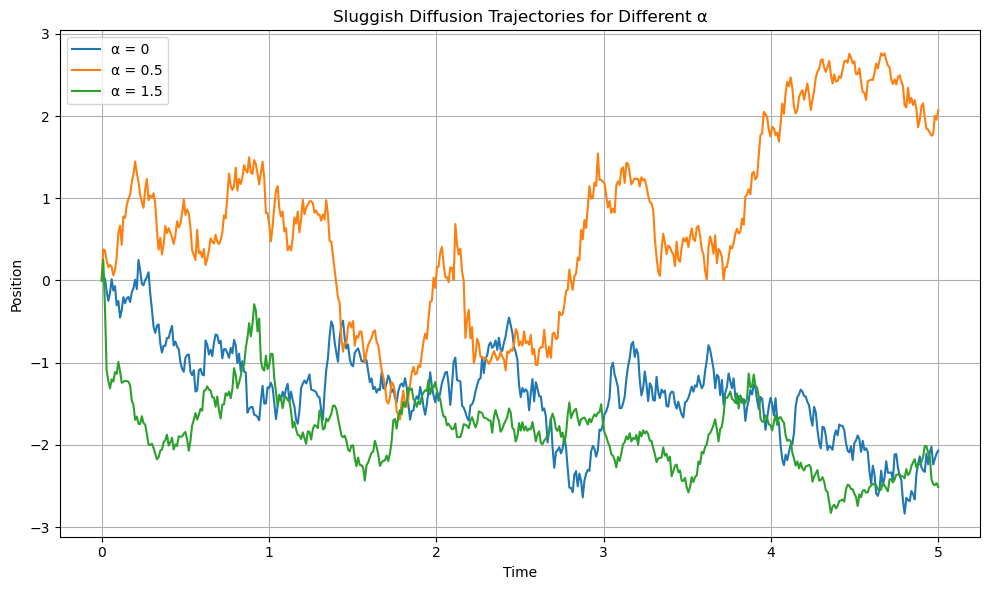

In [ ]:
# Simulation parameters
alphas = [0, 0.5, 1.5]
T = 5
dt = 0.01
x0 = 0

# Plotting
plt.figure(figsize=(10, 6))

for alpha in alphas:
    time, x = sluggish_walk_continuous(alpha, T=T, dt=dt, x0=x0)
    plt.plot(time, x, label=f'α = {alpha}')

plt.title('Sluggish Diffusion Trajectories for Different α')
plt.xlabel('Time')
plt.ylabel('Position')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Probability distribution of final positions

We look at how the spread and shape of the probability distribution of the final positions of a particle undergoing a sluggish random walk.


In a standard unbiased random walk, the final position $x$ after $T$ steps is known to follow a Gaussian distribution according to the central limit theorem:
$$
P(x,t)=\dfrac{1}{\sqrt{2\pi\sigma^2(T)}}\exp{\left(-\dfrac{x^2}{2\sigma^2(T)}\right)}
$$
This is as shown by the probability distribution of $\alpha=0$



For $\alpha > 0$, [1] proposed  
$$
P(x,t) =  
\frac{  
    \left( \frac{1}{\alpha + 2} \right)^{\frac{\alpha}{\alpha + 2}}  
}{  
    2 \Gamma \left( \frac{\alpha + 1}{\alpha + 2} \right)  
}  
\cdot  
\frac{ |x|^{\alpha} }{ t^{\frac{\alpha + 1}{\alpha + 2}} }  
\cdot  
\exp \left(  
    -\frac{ |x|^{\alpha + 2} }{ (\alpha + 2)^2 t }  
\right)
$$  

[1] Giuseppe Del Vecchio and Satya N. Majumdar.  
*Generalized arcsine laws for a sluggish random walker with subdiffusive growth*.  
Journal of Statistical Mechanics: Theory and Experiment, 2025(2):023207, 2025.

### Analytics vs Simulation

In [ ]:
from collections import Counter

In [ ]:
def probability_distribution_ct(T, N, alpha, dt=0.01, x0=0.01, epsilon=5e-2):
    final_positions = []
    for _ in range(N):
        _, x = sluggish_walk_continuous(alpha, T, dt, x0, epsilon)
        # Round positions to make distribution discrete
        pos = round(x[-1], 1)
        final_positions.append(pos)
    return Counter(final_positions)

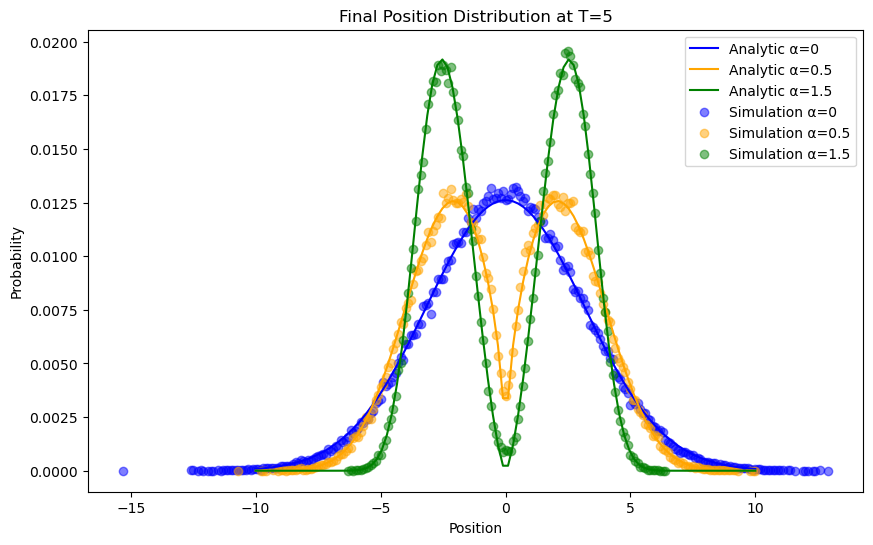

In [ ]:
def P(x, t, alpha):
    A = (1/(alpha + 2))**(alpha / (alpha + 2))
    B = 2 * gamma((alpha + 1) / (alpha + 2))
    C = 1 / ((alpha + 2)**2)

    numerator = np.abs(x)**alpha
    denominator = t**((alpha + 1) / (alpha + 2))
    exponent = -C * (np.abs(x)**(alpha + 2)) / t

    return ((A / B) * (numerator / denominator) * np.exp(exponent)/10)

def plot_combined(T, N, alpha_values, dt=0.01, x0=0.01, epsilon=5e-2):
    colors = ['blue', 'orange', 'green']

    plt.figure(figsize=(10, 6))

    # Plot analytic distribution (smooth curve)
    x = np.linspace(-10, 10, 100)
    for alpha, c in zip(alpha_values, colors):
        y = P(x, T, alpha)
        plt.plot(x, y, label=f'Analytic α={alpha}', color=c)

    # Overlay simulation data (scatter points)
    for alpha, c in zip(alpha_values, colors):
        counts = probability_distribution_ct(T, N, alpha, dt, x0, epsilon)
        xs = np.array(sorted(counts.keys()))
        ps = np.array([counts[x] / N for x in xs])
        plt.scatter(xs, ps, color=c, marker='o', alpha=0.5, label=f'Simulation α={alpha}')

    plt.title(f'Final Position Distribution at T={T}')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(False)
    plt.show()

plot_combined(T=5, N=150000, alpha_values=[0, 0.5, 1.5], dt=0.01)